# MARATONA BEHIND THE CODE 2020

## DESAFIO 4 - CompuSoluciones

### Introducción

En este desafío, CompuSoluciones usará herramientas de IBM como Watson Studio (o Cloud Pack for Data) y Watson Machine Learning para construir un modelo de Machine Learning natural capaz de predecir la probabilidad de cumplimiento de pago.

La idea esencial del Desafío 4 es crear un modelo basado en machine learning capaz de identificar el comportamiento financiero del asociado de negocio, permitiendo una probabilidad de cumplimiento o incumplimiento del crédito.

<hr>

### Instalación de Librerias

In [ ]:
!pip install scikit-learn --upgrade

     |████████████████████████████████| 6.8MB 2.8MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
!pip install scikit-learn==0.22.0 --upgrade

     |████████████████████████████████| 7.0MB 2.6MB/s 
  Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2


In [ ]:
# Si desea utilizar la biblioteca ** xgboost **, instale la versión 0.71.
#!pip install xgboost==0.71 --upgrade

In [ ]:
import json
import requests
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Descargando el dataset csv desde Github

In [ ]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv

--2020-09-10 17:42:04--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751735 (1.7M) [text/plain]
Saving to: ‘reto-4-compu-train.csv’

reto-4-compu-train. 100%[===================>]   1.67M  --.-KB/s    in 0.1s    

2020-09-10 17:42:04 (13.1 MB/s) - ‘reto-4-compu-train.csv’ saved [1751735/1751735]



In [ ]:
df = pd.read_csv(r'reto-4-compu-train.csv')
df.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,239671.50090,1.257907e+06,2356497.733,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,94809.20697,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,610814.63990,1.009937e+07,1444426.243,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1236065.779,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,116647.73960,1.798065e+06,3657339.603,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


In [ ]:
df = df.drop(columns=[
        'CXC',
        'EQ_OFICINA',
        'CONTRIBUCIONES_X_PAGAR',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',

        'CXP',
        'TOTAL_VENTAS',


        'INVENTARIO',
        'UTILIDADES_ACUMULADAS'


    ])

In [ ]:
df.head()

,EFECTIVO,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDAD_O_PERDIDA,TOTAL_GASTOS,OBJETIVO
0,NaN,2.947057e+05,8.812520e+06,1.257907e+06,2356497.733,-6.816681e+06,1.505762e+07,Aceptado
1,7.437098e+04,4.000109e+05,8.491851e+06,6.708985e+05,NaN,-3.342452e+06,1.085156e+07,Aceptado
2,5.269987e+06,3.478673e+06,-1.393229e+07,1.009937e+07,1444426.243,-4.026344e+06,8.680735e+06,Sospechoso
3,9.092134e+05,1.302021e+06,1.379064e+06,2.378928e+06,1236065.779,-4.567435e+06,1.323267e+07,Aceptado
4,9.688669e+05,NaN,-6.297179e+05,1.798065e+06,3657339.603,-7.110320e+05,1.100048e+07,Aceptado


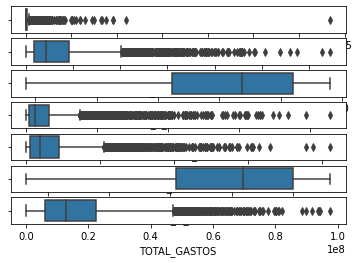

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(nrows=len(df.columns[0:-1]))
for col, idx in zip(df[df.columns[0:-1]],range(len(df.columns[0:-1]))):
  sns.boxplot(x=df[col], ax=axs[idx])

### Acerca del Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EFECTIVO                   7986 non-null   float64
 1   CXC                        7968 non-null   float64
 2   INVENTARIO                 8000 non-null   float64
 3   EQ_OFICINA                 7945 non-null   float64
 4   EQ_TRANSPORTE              7988 non-null   float64
 5   TERRENOS_Y_CONSTRUCCIONES  8038 non-null   float64
 6   CXP                        7934 non-null   float64
 7   CONTRIBUCIONES_X_PAGAR     8052 non-null   float64
 8   ANTICIPOS_CTE              7976 non-null   float64
 9   CAP_SOCIAL                 8036 non-null   float64
 10  UTILIDADES_ACUMULADAS      7993 non-null   float64
 11  UTILIDAD_O_PERDIDA         8031 non-null   float64
 12  TOTAL_VENTAS               7941 non-null   float64
 13  TOTAL_COMPRAS              7908 non-null   float

Las variables son todas numericas. Solo nuestra variable TARGET (Prestamo aprobado o posible incumplimiento financiero) es the tipo float.

La función describe() de abajo muestra varias estadisticas del dataset.

In [ ]:
df.describe()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
count,7.986000e+03,7.968000e+03,8.000000e+03,7.945000e+03,7.988000e+03,8.038000e+03,7.934000e+03,8.052000e+03,7.976000e+03,8.036000e+03,7.993000e+03,8.031000e+03,7.941000e+03,7.908000e+03,7.971000e+03,7.943000e+03
mean,1.720915e+06,1.561073e+07,1.098941e+07,4.341284e+06,1.321588e+06,6.198420e+05,2.275234e+07,4.109997e+05,2.635145e+06,3.325138e+06,4.240122e+06,-2.090086e+06,1.017051e+08,1.211510e+08,1.702067e+07,1.620236e+07
std,5.958844e+06,1.980334e+07,1.541956e+07,1.885512e+07,1.398674e+06,6.202347e+06,2.810091e+07,6.311683e+05,3.828127e+06,4.122756e+06,1.066916e+07,2.439421e+06,1.148423e+08,3.320798e+08,1.710116e+07,1.341951e+07
min,2.591455e+03,3.282261e+01,5.019700e-02,2.974216e+02,1.698222e+02,-1.577708e+07,1.276200e+01,5.638191e+03,4.495763e+00,2.334091e+00,-4.029189e+07,-8.716171e+06,7.154203e+03,1.458903e+05,2.408107e+03,3.979024e+03
25%,1.874601e+05,2.362067e+06,9.281351e+05,1.769855e+05,3.433503e+05,-3.874056e+06,3.711720e+06,1.113298e+05,3.813363e+05,5.629920e+05,-3.025772e+06,-3.824858e+06,2.303181e+07,1.214764e+07,4.836037e+06,6.104123e+06
50%,5.112329e+05,8.255125e+06,4.810330e+06,6.529255e+05,8.630635e+05,1.828932e+06,1.286143e+07,2.288855e+05,1.235872e+06,1.870131e+06,4.119952e+06,-1.629044e+06,6.309045e+07,3.473485e+07,1.181114e+07,1.272461e+07
75%,1.432613e+06,2.160462e+07,1.474278e+07,2.430901e+06,1.827559e+06,5.955197e+06,3.097250e+07,4.690705e+05,3.273238e+06,4.536913e+06,1.140550e+07,-7.368186e+03,1.378293e+08,1.007433e+08,2.352766e+07,2.260017e+07
max,3.343603e+08,2.135761e+08,1.664338e+08,5.913821e+08,1.290365e+07,9.031323e+06,2.644946e+08,1.618323e+07,4.291686e+07,4.116688e+07,4.056842e+07,1.214191e+06,1.151511e+09,1.000136e+10,1.438985e+08,9.763166e+07


<hr>

### Entrenamiento y evaluación de un modelo de clasificación binaria


#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos transform y fit. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación DropColumns para eliminar columnas de un pandas DataFrame.


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin



# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        df_data = pd.DataFrame(data=data, columns=self.columns[1])
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return df_data.drop(labels=self.columns[0], axis='columns')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

# All sklearn Transforms must have the `transform` and `fit` methods
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()

        
        for column in self.columns:
  
          try:
            X_ = X.dropna(subset=[list(X.corr()[(X.corr() >= 0.75) & (X.corr() < 1)][column].dropna().sort_values()[::-1].index)[0]])
            newX = X_[[list(X.corr()[(X.corr() >= 0.75) & (X.corr() < 1)][column].dropna().sort_values()[::-1].index)[0]]+[column]]
            newX_train = newX[np.isnan(X_[column])==False]


            LinReg = LinearRegression()
            LinReg.fit(newX_train[[list(X.corr()[(X.corr() >= 0.75) & (X.corr() < 1)][column].dropna().sort_values()[::-1].index)[0]]], newX_train[column])

            valores_imputacion = newX[np.isnan(X_[column])]
            valores_imputacion = valores_imputacion[[list(X.corr()[(X.corr() >= 0.75) & (X.corr() < 1)][column].dropna().sort_values()[::-1].index)[0]]]

            nuevos_valores = LinReg.predict(valores_imputacion)
            X_.loc[np.isnan(X_[column]), column] = nuevos_valores  
            data.loc[X_.index, column] = X_[column]

          except:
            pass

        
        return data

In [ ]:
from keras.layers import Dropout 
from keras import regularizers  
def baseline_model():
    model = Sequential()
    model.add(Dense(128,
                    activation = 'relu',
                    input_dim = 7,
                    activity_regularizer = regularizers.l2(1e-5)))
    model.add(Dropout(0.50))
    model.add(Dense(128,
                    activation = 'relu', 
                    activity_regularizer = regularizers.l2(1e-5)))
    model.add(Dropout(0.50))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(15, activation = 'linear'))

    model.add(Dense(1, activation = 'sigmoid'))
    # create model

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
'''
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(15, activation = 'linear'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

SyntaxError: ignored

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=4, verbose=1)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTETomek
from sklearn.impute import KNNImputer
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.pipeline import Pipeline


pipeline = Pipeline(
    steps=[
        ('paso_1',  CustomTransformer(
    columns=[
        'EFECTIVO',
        'CXC',

        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
)),
('paso_2', KNNImputer(n_neighbors=51)),
('paso_3', DropColumns(
    columns=[[
        'CXC',
        'EQ_OFICINA',
        'CONTRIBUCIONES_X_PAGAR',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',

        'CXP',
        'TOTAL_VENTAS',


        'INVENTARIO',
        'UTILIDADES_ACUMULADAS'


    ],['EFECTIVO',
        'CXC',

        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS']]
)),
('paso_4', SMOTETomek(sampling_strategy=0.3)),
('paso_5', RandomUnderSampler(ratio={0:3500})),
('paso_6', StandardScaler()),
('paso_7', estimator)




    ]
)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
pipeline_input = df[
    [
        'EFECTIVO',
        'CXC',

        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]

pipeline_target = df['OBJETIVO']

In [ ]:
####
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(pipeline_target.values)
y = le.transform(pipeline_target.values)
print(y.shape)
print(y[0:30])
###

(9400,)
[0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    pipeline_input,
    y,
    test_size=0.2,
    random_state=21233
)

In [ ]:
s_1 = CustomTransformer(
    columns=[
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
)
s_1.fit(X_test)
X_test = s_1.transform(X_test)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/p

In [ ]:
##########
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=51) #arbitrary
X_values = imputer.fit_transform(X_test.values)
X_test.loc[:,:] = X_values

In [ ]:
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_test, y_test = undersampler.fit_sample(X_test, y_test)
print(y_test.shape)

(234,)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pipeline.fit(X_train, y_train) 
y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/p

Epoch 1/50
1405/1405 [==============================] - 2s 1ms/step - loss: 0.2503 - accuracy: 0.8918
Epoch 2/50
1405/1405 [==============================] - 2s 1ms/step - loss: 0.1795 - accuracy: 0.9262
Epoch 3/50
1405/1405 [==============================] - 2s 1ms/step - loss: 0.1677 - accuracy: 0.9285
Epoch 4/50
1405/1405 [==============================] - 2s 1ms/step - loss: 0.1575 - accuracy: 0.9368
Epoch 5/50
1405/1405 [==============================] - 2s 1ms/step - loss: 0.1584 - accuracy: 0.9370
Epoch 6/50
1405/1405 [==============================] - 2s 1ms/step - loss: 0.1541 - accuracy: 0.9395
Epoch 7/50
1405/1405 [==============================] - 2s 1ms/step - loss: 0.1541 - accuracy: 0.9399
Epoch 8/50
1405/1405 [==============================] - 2s 1ms/step - loss: 0.1471 - accuracy: 0.9411
Epoch 9/50
1405/1405 [==============================] - 2s 1ms/step - loss: 0.1461 - accuracy: 0.9416
Epoch 10/50
1405/1405 [==============================] - 2s 1ms/step - loss: 0.142

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.902\nPrecision=0.912\nRecall=0.889\nF1 Score=0.9004329004329005')

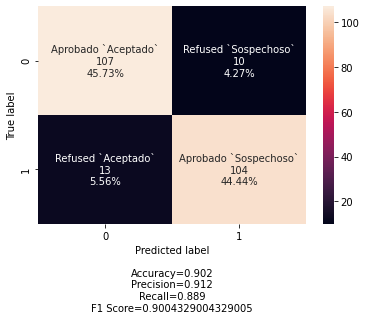

In [ ]:

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [ ]:
#https://onezero.blog/hyperparameter-tuning-of-keras-deep-learning-model-in-python/
#https://media.discordapp.net/attachments/739255396748754985/748313124880515092/unknown.png

#### Transformación 3: tratamiento de datos faltantes

Para manejar los datos que faltan en nuestro conjunto de datos, ahora usaremos una transformación lista para usar de la biblioteca scikit-learn, llamada SimpleImputer.

Esta transformación permite varias estrategias para el tratamiento de datos faltantes. La documentación oficial se puede encontrar en: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

En este ejemplo, simplemente haremos cero todos los valores faltante usted puede escoger otra estrategia ;).

In [ ]:
# Crear un objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='constant',  # la estrategia elegida es cambiar el valor faltante por una constante
    fill_value=0,  # la constante que se usará para completar los valores faltantes es un int64 = 0
    verbose=0,
    copy=True
)

print(si)

In [ ]:
# Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))

# Aplicamos el SimpleImputer ``si`` al conjunto de datos df_data_2 (resultado de la primera transformación)
si.fit(X=df2)

# Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df2
    ),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=df2.columns  # las columnas originales deben conservarse en esta transformación
)

# Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_3)
print("\n\nValores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(df3.isnull().sum(axis = 0)))

#### Definición de features (Variables Independientes)

En este * ejemplo * usaremos todas las columnas. (Usted debe decidir cuales variables utilizar)

In [ ]:
# Definiendo las variables features y target (removed CXC and CXP)

features = df3[
    [
        'EFECTIVO',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]
target = df3["OBJETIVO"]  ## No cambie la variable target!

#### División en 80% entrenamiento y 20% pruebas

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=None)

#### Entrenando un modelo ``DecisionTreeClassifier()``

In [ ]:
# Método para creacion de modelos basados en arbol de desición
from sklearn.tree import DecisionTreeClassifier

dtc_model = DecisionTreeClassifier(max_depth=3)
model = dtc_model.fit(X_train, y_train)

#### Haciendo una predicción con el set de prueba

In [ ]:
y_pred = dtc_model.predict(X_test)
print(y_pred)

#### Analizar la calidad del modelo a través de la matriz de confusión

In [ ]:

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

##### ¡ATENCIÓN! Su puntuación en este desafío de clasificación se basará en la puntuación F1 del modelo al predecir el dataset de evaluación.

<hr>

## Puntuación de los datos necesarios para entregar la solución

Como entrega de su solución, esperamos que los resultados se clasifiquen en el siguiente conjunto de datos llamado "to_be_scored_compusoluciones.csv":

### Descarga la "hoja de evaluación"

In [ ]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_compusoluciones.csv')
df_to_be_scored.tail()

--2020-09-10 17:42:53--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100124 (98K) [text/plain]
Saving to: ‘to_be_scored_compusoluciones.csv’

to_be_scored_compus 100%[===================>]  97.78K  --.-KB/s    in 0.04s   

2020-09-10 17:42:54 (2.61 MB/s) - ‘to_be_scored_compusoluciones.csv’ saved [100124/100124]



,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
595,3.893725e+06,5.279410e+06,9.811669e+02,1.757291e+07,3.989011e+06,-1.545727e+07,2.497177e+06,103003.8264,2402813.337,NaN,1.751228e+07,-4050340.635,8.830412e+07,1.147548e+08,NaN,1.858752e+06
596,8.806031e+05,3.354813e+07,NaN,5.241604e+06,NaN,-1.727618e+06,4.021914e+07,821297.6732,3154291.078,NaN,1.636395e+07,-2394015.114,1.257229e+08,7.169861e+07,2.675382e+07,2.455403e+07
597,NaN,2.711050e+07,3.260820e+06,4.681080e+06,NaN,-3.291876e+06,3.763157e+07,NaN,1861471.266,942635.7885,7.126997e+06,NaN,6.531900e+07,1.014415e+08,2.333685e+07,NaN
598,7.443979e+06,4.076322e+07,6.408235e+06,1.507174e+07,6.257927e+05,-7.237902e+06,6.080636e+07,NaN,5220998.681,NaN,9.928204e+06,-3351032.988,9.340985e+07,1.571700e+08,3.062958e+07,3.042192e+07
599,5.611681e+05,6.438914e+06,3.867058e+06,4.545890e+05,1.949220e+06,-3.280783e+06,NaN,427294.9401,3954071.593,532328.4053,1.823676e+07,-5664180.434,1.059266e+08,5.820347e+07,5.238135e+05,2.470879e+06


# ¡Atención!

El Dataframe ``to_be_scored_compusoluciones`` es su "hoja de evaluación". Tenga en cuenta que a la columna "OBJETIVO" le faltan datos en este ejemplo, que luego no se pueden usar para entrenar modelos de aprendizaje supervisado.

In [ ]:
df_to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EFECTIVO                   511 non-null    float64
 1   CXC                        511 non-null    float64
 2   INVENTARIO                 511 non-null    float64
 3   EQ_OFICINA                 505 non-null    float64
 4   EQ_TRANSPORTE              513 non-null    float64
 5   TERRENOS_Y_CONSTRUCCIONES  513 non-null    float64
 6   CXP                        523 non-null    float64
 7   CONTRIBUCIONES_X_PAGAR     499 non-null    float64
 8   ANTICIPOS_CTE              515 non-null    float64
 9   CAP_SOCIAL                 504 non-null    float64
 10  UTILIDADES_ACUMULADAS      496 non-null    float64
 11  UTILIDAD_O_PERDIDA         514 non-null    float64
 12  TOTAL_VENTAS               506 non-null    float64
 13  TOTAL_COMPRAS              527 non-null    float64

<hr>

# ¡Atención!

# Para aplicar su modelo y clasificar la hoja de evaluación, primero debe aplicar las mismas transformaciones de columnas que aplicó al conjunto de datos de entrenamiento.

# No elimine ni agregue líneas a la hoja de respuestas.

# No cambie el orden de las líneas en la hoja de respuestas.

# Al final, se deben clasificar las 600 entradas, con los valores calculados en la columna "target"

<hr>

In [ ]:
df_to_be_scored.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
0,1.402839e+06,44583071.51,17579093.50,1.648525e+06,5.027861e+05,1.050458e+06,53144319.00,2.076978e+06,5.822111e+06,1.235629e+07,1.180115e+07,-4.952369e+06,9.350929e+07,1.485613e+08,2.026458e+07,2.544413e+07
1,1.850961e+05,11144636.79,36407677.13,4.214732e+05,2.913787e+06,NaN,NaN,7.095447e+04,2.403460e+06,1.348782e+05,9.051638e+06,-6.260910e+06,1.958889e+08,4.901225e+08,1.892297e+07,NaN
2,8.055658e+06,83094868.07,7723528.23,1.187192e+08,5.021466e+06,-1.197336e+07,81723630.93,9.482034e+05,2.056313e+07,2.461496e+05,NaN,-5.931161e+06,NaN,6.676051e+08,2.661718e+07,NaN
3,9.843232e+04,5876109.56,3991008.27,5.847962e+05,4.072740e+04,5.300208e+06,16434719.41,NaN,1.232947e+06,3.710336e+05,9.367407e+06,-4.511669e+06,NaN,NaN,9.875365e+06,6.535524e+06
4,NaN,23696999.62,36624028.71,NaN,3.222506e+06,NaN,50356975.02,5.668446e+05,7.996380e+06,1.354648e+07,8.604879e+06,-1.924530e+05,3.397666e+08,9.354509e+07,NaN,2.903567e+07


In [ ]:
s_1 = CustomTransformer(
    columns=[
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
)
s_1.fit(df_to_be_scored)
df_to_be_scored = s_1.transform(df_to_be_scored)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/p

In [ ]:
##########
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=51) #arbitrary
X_values = imputer.fit_transform(df_to_be_scored.values)
df_to_be_scored.loc[:,:] = X_values

In [ ]:
# Realización de una prueba a ciegas en el modelo creado
y_pred = pipeline.predict(df_to_be_scored.values)

In [ ]:
y_pred[0:50]

array([[1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
y_pred_str = np.array(['Sospechoso' if x == 1 else 'Aceptado' for x in y_pred])

In [ ]:
y_pred_str = y_pred_str.reshape(y_pred_str.shape[0],1)

In [ ]:
y_pred_str[0:50]

array([['Sospechoso'],
       ['Sospechoso'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Sospechoso'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Sospechoso'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
       ['Aceptado'],
     

In [ ]:
# Agregando las respuestas en la columna "target"
df_to_be_scored['target'] = y_pred_str
df_to_be_scored.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,target
0,1.402839e+06,44583071.51,17579093.50,1.648525e+06,5.027861e+05,1.050458e+06,5.314432e+07,2.076978e+06,5.822111e+06,1.235629e+07,1.180115e+07,-4.952369e+06,9.350929e+07,1.485613e+08,2.026458e+07,2.544413e+07,Sospechoso
1,1.850961e+05,11144636.79,36407677.13,4.214732e+05,2.913787e+06,-2.138664e+06,1.504889e+07,7.095447e+04,2.403460e+06,1.348782e+05,9.051638e+06,-6.260910e+06,1.958889e+08,4.901225e+08,1.892297e+07,1.762752e+07,Sospechoso
2,8.055658e+06,83094868.07,7723528.23,1.187192e+08,5.021466e+06,-1.197336e+07,8.172363e+07,9.482034e+05,2.056313e+07,2.461496e+05,1.216269e+07,-5.931161e+06,1.355712e+08,6.676051e+08,2.661718e+07,2.306791e+07,Aceptado
3,9.843232e+04,5876109.56,3991008.27,5.847962e+05,4.072740e+04,5.300208e+06,1.643472e+07,3.068873e+05,1.232947e+06,3.710336e+05,9.367407e+06,-4.511669e+06,6.077052e+07,5.798939e+07,9.875365e+06,6.535524e+06,Aceptado
4,1.637193e+06,23696999.62,36624028.71,2.891993e+06,3.222506e+06,-2.005656e+06,5.035698e+07,5.668446e+05,7.996380e+06,1.354648e+07,8.604879e+06,-1.924530e+05,3.397666e+08,9.354509e+07,3.196543e+07,2.903567e+07,Aceptado


In [ ]:
print(df_to_be_scored.values.shape)

(600, 17)


In [ ]:
df_to_be_scored.isna().sum()

EFECTIVO                     0
CXC                          0
INVENTARIO                   0
EQ_OFICINA                   0
EQ_TRANSPORTE                0
TERRENOS_Y_CONSTRUCCIONES    0
CXP                          0
CONTRIBUCIONES_X_PAGAR       0
ANTICIPOS_CTE                0
CAP_SOCIAL                   0
UTILIDADES_ACUMULADAS        0
UTILIDAD_O_PERDIDA           0
TOTAL_VENTAS                 0
TOTAL_COMPRAS                0
UTILIDAD_BRUTA               0
TOTAL_GASTOS                 0
target                       0
dtype: int64

In [ ]:
df_to_be_scored.to_csv('/content/drive/My Drive/Colab Notebooks/results.csv')

En la celda de abajo, repetimos rápidamente los mismos pasos de preprocesamiento usados ​​en el ejemplo dado con el árbol de decisiones

### Guardar la hoja de respuestas como un archivo .csv para enviar
**SI YA TIENE UN DATA ASSET CON EL NOMBRE `results.csv` EN ESTE PROYECTO O EN OTRO PROYECTO DE WATSON STUDIO DEBE BORRAR EL ARCHIVO ANTES DE CORRER LA SIGUIENTE CELDA O TENDRA EL ERROR: _RuntimeError: File 'results.csv' already exists in storage._**

In [ ]:
project.save_data(file_name="results.csv", data=df_to_be_scored_3.to_csv(index=False))

# Atención

# La ejecución de la celda anterior creará un nuevo "data asset" en su proyecto de Watson Studio. Deberá descargar este archivo junto con este cuaderno y crear un archivo zip con **results.csv** y **notebook.ipynb** para enviarlo. (los archivos deben tener este nombre)

<hr>

## ¡Felicitaciones! 

Si ya está satisfecho con su solución, vaya a la página siguiente y envíe los archivos necesarios para su envío.

# https://compusoluciones.maratona.dev